# Adversarial Search: Playing Connect 4

Student Name: Ephraim Sun

I have used the following AI tools:

I understand that my submission needs to be my own work: E.S.

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial State: The initial state is an empty game board with all positions set to 0

Actions: In each state, the available actions are dropping a checker into one of the columns of the board that is not full

Transition model: The result function takes a state and an action as input and returns the new state after applying the action. It updates the board by placing the checker of the current player in the chosen column, occupying the lowest available position in that column.

Goal state (terminal state and utility): The goal state is reached when one of the players has formed a horizontal, vertical, or diagonal line of four checkers of their own color, or when the game board is completely filled. If a player wins, the utility value is +1 for the winning player and -1 for the losing player. If the game ends in a draw, the utility value is 0.


How big is the state space? Give an estimate and explain it.

The state space of Connect 4 refers to the total number of possible game board positions. For classic Connect Four played on a 7-column-wide, 6-row-high grid, there are 4,531,985,219,092 (~4.5 x 10^13) positions for all game boards populated with 0 to 42 pieces.

Each position can be empty, occupied by a red checker, or occupied by a yellow checker. This gives us 3 possibilities for each position. Since there are 42 positions on the board, the total number of possible configurations is 3^42.


How big is the game tree that minimax search will go through? Give an estimate and explain it.

Since the game board has 7 columns, the branching factor is 7. Additionally, the depth of the tree for minimax search is (7 × 6 = 42), which is the longest a game could possibly be. Therefore, the upper bound on the game tree is 7^42. The actual size of the game tree can vary depending on factors such as the depth of the search, the specific rules of the game, and the presence of any optimizations or heuristics used in the minimax algorithm.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

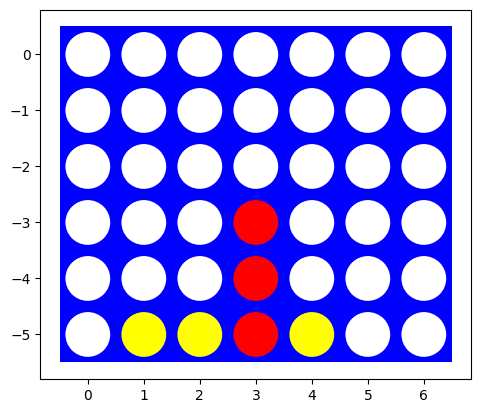

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
import numpy as np
import random

def actions(s):
    return np.where(s[0] == 0)[0].tolist()

def result(s, a, player):
    new_s = np.copy(s)
    row = np.where(new_s[:, a] == 0)[0][-1]
    if np.any(new_s[row, a] == 0):
        new_s[row, a] = player
    return new_s

def check_connect_four(line):
    diffs = np.diff(line)
    consecutive_zeros = np.where(diffs == 0)[0]
    for idx in consecutive_zeros:
        if np.all(line[idx:idx+5] != 0):
            return line[idx]
    return 0

def terminal(s):
    rows, cols = s.shape

    # Check rows
    for row in s:
        if check_connect_four(row) != 0:
            return True

    # Check columns
    for col in range(cols):
        if check_connect_four(s[:, col]) != 0:
            return True

    # Check diagonals
    for d in range(-rows + 1, cols):
        diag1 = np.diagonal(s, offset=d)
        diag2 = np.diagonal(np.fliplr(s), offset=d)
        if check_connect_four(diag1) != 0 or check_connect_four(diag2) != 0:
            return True

    return False

def utility(s):
    rows, cols = s.shape

    # Check rows
    for row in s:
        winner = check_connect_four(row)
        if winner != 0:
            return winner

    # Check columns
    for col in range(cols):
        winner = check_connect_four(s[:, col])
        if winner != 0:
            return winner

    # Check diagonals
    for d in range(-rows + 1, cols):
        diag1 = np.diagonal(s, offset=d)
        diag2 = np.diagonal(np.fliplr(s), offset=d)
        winner = check_connect_four(diag1)
        if winner != 0:
            return winner
        winner = check_connect_four(diag2)
        if winner != 0:
            return winner

    return 0

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

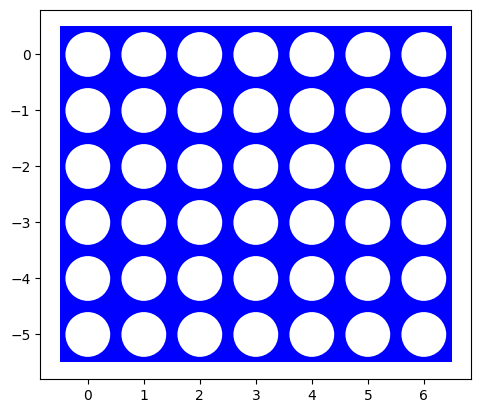

In [4]:
import random

def random_player(board, player=1):
    empty_squares = np.where(board[0] == 0)[0].tolist()
    action = random.choice(empty_squares)
    return action

board = empty_board()
next_move = random_player(board, player=1)
visualize(board)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
def play_game(player1, player2):
    board = empty_board()
    current_player = 1
    while not terminal(board):
        if current_player == 1:
            action = player1(board, player=1)
        else:
            action = player2(board, player=-1)
        board = result(board, action, current_player)
        current_player *= -1
    return utility(board)


num_games = 1000
results = {"Player 1 (Red)": 0, "Player 2 (Yellow)": 0, "Draw": 0}

for _ in range(num_games):
    game_result = play_game(random_player, random_player)
    if game_result == 1:
        results["Player 1 (Red)"] += 1
    elif game_result == -1:
        results["Player 2 (Yellow)"] += 1
    else:
        results["Draw"] += 1

print("Results after {} games:".format(num_games))
for player, num_wins in results.items():
    print("{}: {} wins".format(player, num_wins))

Results after 1000 games:
Player 1 (Red): 560 wins
Player 2 (Yellow): 440 wins
Draw: 0 wins


The result is expected as it should be around 50/50 because the moves are random between the two agents. If you remove the draws between player 1 and player 2, the wins between the agents are close to 50/50.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [6]:
class MinimaxAgent:
    def __init__(self, player, depth=4):
        self.player = player
        self.depth = depth

    def minimax(self, board, depth, alpha, beta, maximizingPlayer):
        if terminal(board) or depth == 0:
            return utility(board)

        if maximizingPlayer:
            maxEval = float('-inf')
            for action in actions(board):
                new_board = result(board, action, self.player)
                eval = self.minimax(new_board, depth - 1, alpha, beta, False)
                maxEval = max(maxEval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return maxEval
        else:
            minEval = float('inf')
            for action in actions(board):
                new_board = result(board, action, -self.player)
                eval = self.minimax(new_board, depth - 1, alpha, beta, True)
                minEval = min(minEval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return minEval

    def choose_move(self, board):
        best_val = float('-inf')
        best_move = None
        for action in actions(board):
            new_board = result(board, action, self.player)
            move_val = self.minimax(new_board, self.depth, float('-inf'), float('inf'), False)
            if move_val > best_val:
                best_val = move_val
                best_move = action
        return best_move

def minimax_player(board, player=1):
    agent = MinimaxAgent(player)
    return agent.choose_move(board)

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

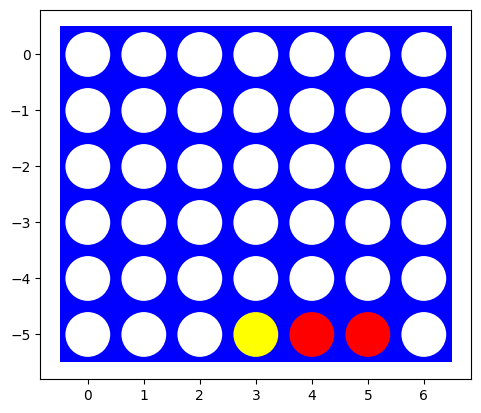

Minimax Agent's Move: Column 3



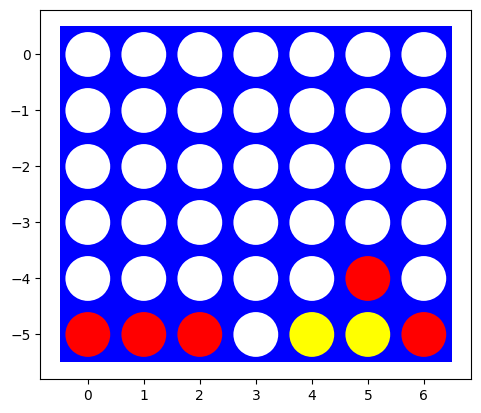

Minimax Agent's Move: Column 3



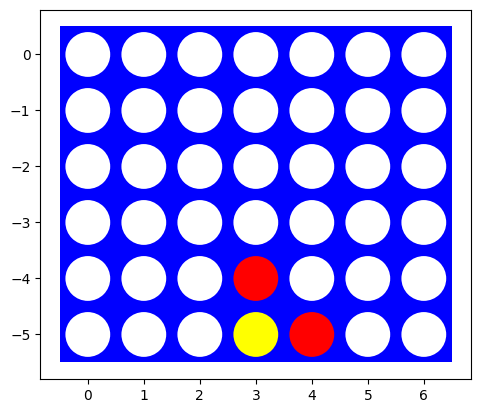

Minimax Agent's Move: Column 0



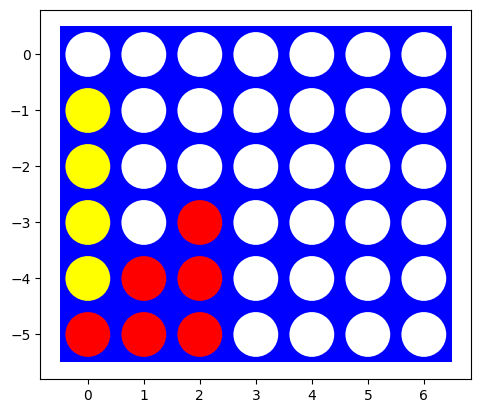

Minimax Agent's Move: Column 0



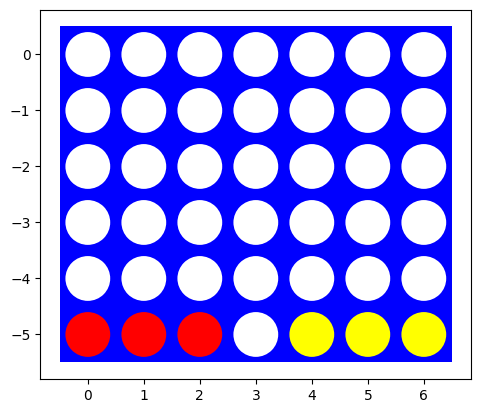

Minimax Agent's Move: Column 3



In [7]:
boards = [
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, -1, 1, 1, 0]
    ]),
np.array([[ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 1, 0],
        [ 1, 1, 1, 0,-1,-1, 1]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, -1, 1, 0, 0]
    ]),
    np.array([[ 0, 0, 0, 0, 0, 0, 0],
        [-1, 0, 0, 0, 0, 0, 0],
        [-1, 0, 0, 0, 0, 0, 0],
        [-1, 0, 1, 0, 0, 0, 0],
        [-1, 1, 1, 0, 0, 0, 0],
        [ 1, 1, 1, 0, 0, 0, 0]
    ]),
    np.array([[ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 0, 0, 0, 0, 0, 0, 0],
        [ 1, 1, 1, 0,-1,-1,-1]
    ])
]

# Create an instance of the Connect4Agent
agent = MinimaxAgent(player=1)  # Assuming the agent plays as player 1

for board in boards:
    visualize(board)
    next_move = minimax_player(board, player=1)
    print(f"Minimax Agent's Move: Column {next_move}\n")


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

Board 1:


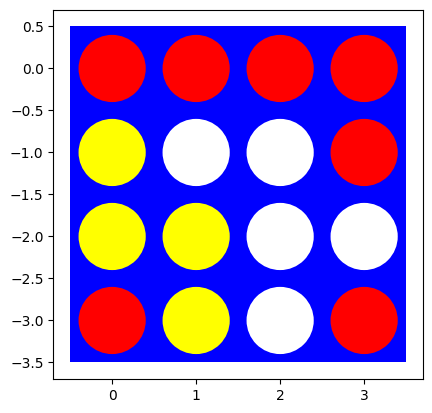

Minimax Agent's Move: Column None
Move Time: 2.6702880859375e-05 seconds

Board 2:


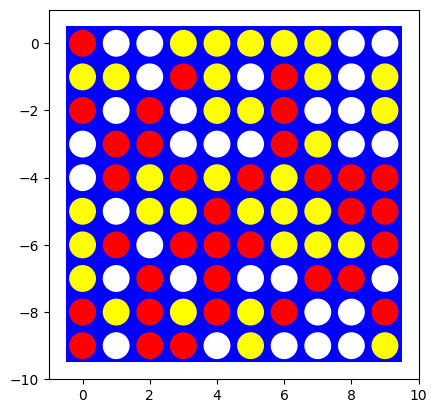

In [8]:
import numpy as np
import time

# Define the number of rows and columns for the boards
row_cols_list = [(4, 4), (10, 10), (25, 25), (50, 50)]

# Define the boards and agent
boards = []
for rows, cols in row_cols_list:
    # Randomize the initial board
    board = np.random.randint(low=-1, high=2, size=(rows, cols))
    boards.append(board)

agent = MinimaxAgent(player=1)

# Measure the time for each move
for i, board in enumerate(boards):
    print(f"Board {i + 1}:")
    visualize(board)
    start_time = time.time()
    next_move = minimax_player(board, player=1)
    end_time = time.time()
    move_time = end_time - start_time
    print(f"Minimax Agent's Move: Column {next_move}")
    print(f"Move Time: {move_time} seconds\n")

As the boards become bigger, the time increases exponentially.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

Simple Move Ordering Strategy:

Prioritize moves that have a higher likelihood of leading to a win or a favorable outcome


In [ ]:
class MoveOrderingAgent(MinimaxAgent):
    def __init__(self, player, depth=4):
        super().__init__(player, depth)

    def order_moves(self, board):
        # Order moves based on the number of available adjacent slots
        scores = []
        for move in actions(board):
            move_coords = (0, move)  # Convert move to coordinates
            score = self.evaluate_move(board, move_coords)
            scores.append((move_coords, score))

        # Sort moves based on scores in descending order
        ordered_moves = sorted(scores, key=lambda x: x[1], reverse=True)

        return [move for move, _ in ordered_moves]

    def evaluate_move(self, board, move):
        # Calculate the score based on the heuristic

        # Get the dimensions of the board
        rows, cols = board.shape

        # Count the number of available adjacent slots to the move
        count = 0

        # Check horizontal adjacent slots
        row = move[0]
        for col in range(move[1] - 1, move[1] + 2):
            if col >= 0 and col < cols and board[row, col] == 0:
                count += 1

        # Check vertical adjacent slots
        col = move[1]
        for row in range(move[0] - 1, move[0] + 2):
            if row >= 0 and row < rows and board[row, col] == 0:
                count += 1

        return count
    
    def choose_move(self, board):
        best_val = float('-inf')
        best_move = None
        for action in self.order_moves(board):
            new_board = result(board, action, self.player)
            move_val = self.minimax(new_board, self.depth, float('-inf'), float('inf'), False)
            if move_val > best_val:
                best_val = move_val
                best_move = action
        return best_move

def move_ordering_player(board, player=1):
    agent = MoveOrderingAgent(player)
    return agent.choose_move(board)

In [ ]:
import numpy as np
import time
import pandas as pd

def time_agent_move(board, agent):
    start_time = time.time()
    agent.choose_move(board)
    end_time = time.time()
    return end_time - start_time

results = []
for cols in range(4, 8):
    board = empty_board(shape=(6, cols))

    minimax_agent = MinimaxAgent(player=1, depth=4)
    minimax_time = time_agent_move(board, minimax_agent)

    ordered_minimax_agent = MoveOrderingAgent(player=1, depth=4)
    ordered_minimax_time = time_agent_move(board, ordered_minimax_agent)

    results.append((cols, minimax_time, ordered_minimax_time))

df = pd.DataFrame(results, columns=['Board Columns', 'Minimax Time (s)', 'Ordered Minimax Time (s)'])
df



### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

Heuristic: Evaluate the position based on the number of player's pieces in potential winning positions

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Example 1: Winning opportunity for player 1
board1 = [
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
]

# Example 2: Winning opportunity for player -1
board2 = [
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0]
]

# Example 3: No winning opportunity for either player
board3 = [
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0]
]

# Create instances of Connect4GameWithMinimax
game1 = Connect4GameWithMinimaxAlphaBeta(rows=6, columns=7)
game2 = Connect4GameWithMinimaxAlphaBeta(rows=6, columns=7)
game3 = Connect4GameWithMinimaxAlphaBeta(rows=6, columns=7)

# Set the board states
game1.board = board1
game2.board = board2
game3.board = board3

# Call the minimax_with_alpha_beta method to find the best move
depth = 3
move1, eval1 = game1.minimax_with_alpha_beta(depth, float('-inf'), float('inf'), True)
move2, eval2 = game2.minimax_with_alpha_beta(depth, float('-inf'), float('inf'), True)
move3, eval3 = game3.minimax_with_alpha_beta(depth, float('-inf'), float('inf'), True)

# Print the results
print("Example 1:")
print("Best Move:", move1)
print("Evaluation:", eval1)
print("")

print("Example 2:")
print("Best Move:", move2)
print("Evaluation:", eval2)
print("")

print("Example 3:")
print("Best Move:", move3)
print("Evaluation:", eval3)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Our Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.